In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
from PIL import Image

In [ ]:
# split video into frames
# Dont run this if you already have the frames
# import cv2
# vidcap = cv2.VideoCapture('lane_video.mp4')
# success,image = vidcap.read()
# count = 0
# if not success:
#     print('failed')
# while success:
#   cv2.imwrite("/Users/MattWalsh/Desktop/Files/School/CS6434/Project/frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
#   success,image = vidcap.read()
#   count += 1

In [ ]:
# reduce images to 300x168 grayscale pixels
# Dont run this if you already have the frames
# num_images = 1260

# for i in range(num_images):
#     basewidth = 300
#     img = Image.open("/Users/MattWalsh/Desktop/Files/School/CS6434/Project/frames/frame%d.jpg" % i)
#     wpercent = (basewidth / float(img.size[0]))
#     hsize = int((float(img.size[1]) * float(wpercent)))
#     img = img.resize((basewidth, hsize), Image.ANTIALIAS)
#     imgGray = img.convert('L')
#     imgGray.save("/Users/MattWalsh/Desktop/Files/School/CS6434/Project/reduced_frames/frame%d_reduced.jpg" % i)

In [34]:
# load in data
num_images = 1260
train = []
test = []
for i in range(num_images):
    img = Image.open("reduced_frames/frame%d_reduced.jpg" % i)
    if np.random.rand() > 0.2:
        train.append(np.array(img))
    else:
        test.append(np.array(img))
        
trainX = np.asarray(train)
testX = np.asarray(test)
print(testX.shape)
print(trainX.shape)

(247, 168, 300)
(1013, 168, 300)


Actual Image:


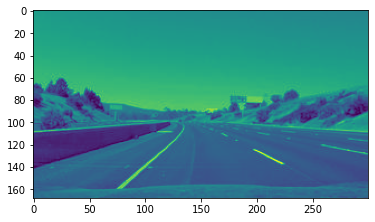

Image with Noise:


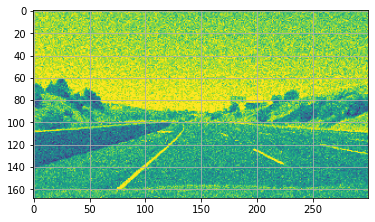

In [35]:
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX / 255.0
testX = testX / 255.0

trainNoise = np.random.normal(loc=0.3, scale=0.1, size=trainX.shape)
testNoise = np.random.normal(loc=0.3, scale=0.1, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

print("Actual Image:")
plt.imshow(testX[0].reshape((168,300)))
plt.show()
print("Image with Noise:")
plt.grid(None)
plt.imshow(testXNoisy[0].reshape((168,300)))

In [36]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        # initialize the input shape to be "channels last" along with
        # the channels dimension itself
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1
        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        # build the encoder model
        encoder = Model(inputs, latent, name="encoder")
        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2,
            padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")
        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)),
        name="autoencoder")
        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

In [37]:
# training 
EPOCHS = 20
BS = 32
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(300, 168, 1)
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=EPOCHS,
	batch_size=BS)


[INFO] building autoencoder...
Epoch 1/20
32/32 [==============================] - 58s 2s/step - loss: 0.0267 - val_loss: 0.0337
Epoch 2/20
32/32 [==============================] - 57s 2s/step - loss: 0.0115 - val_loss: 0.0349
Epoch 3/20
32/32 [==============================] - 55s 2s/step - loss: 0.0084 - val_loss: 0.0326
Epoch 4/20
32/32 [==============================] - 55s 2s/step - loss: 0.0071 - val_loss: 0.0300
Epoch 5/20
32/32 [==============================] - 56s 2s/step - loss: 0.0063 - val_loss: 0.0272
Epoch 6/20
32/32 [==============================] - 53s 2s/step - loss: 0.0057 - val_loss: 0.0249
Epoch 7/20
32/32 [==============================] - 56s 2s/step - loss: 0.0051 - val_loss: 0.0222
Epoch 8/20
32/32 [==============================] - 55s 2s/step - loss: 0.0048 - val_loss: 0.0187
Epoch 9/20
32/32 [==============================] - 56s 2s/step - loss: 0.0044 - val_loss: 0.0161
Epoch 10/20
32/32 [==============================] - 57s 2s/step - loss: 0.0041 - val_l

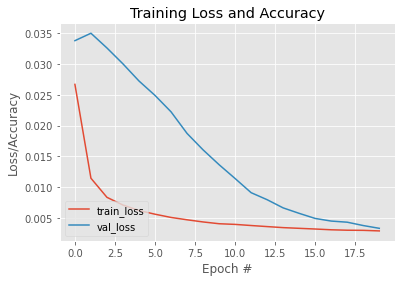

In [38]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Actual Image:


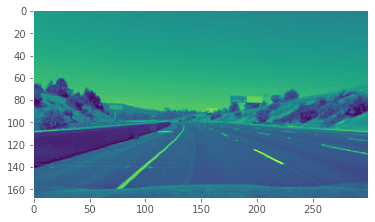

Image with Noise:
(168, 300, 1)


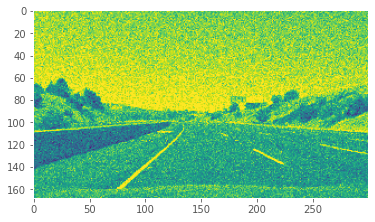

Reconstructed Image


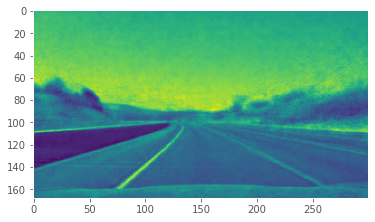

In [39]:
plt.grid(None)
print("Actual Image:")
plt.imshow(testX[0].reshape((168,300)))
plt.show()
print("Image with Noise:")
plt.grid(None)
plt.imshow(testXNoisy[0].reshape((168,300)))
print(testXNoisy[0].shape)
plt.show()
recon = autoencoder(testXNoisy[0].reshape(1,168,300,1)).numpy()
print("Reconstructed Image")
plt.grid(None)
plt.imshow(recon.reshape((168,300)))
plt.show()

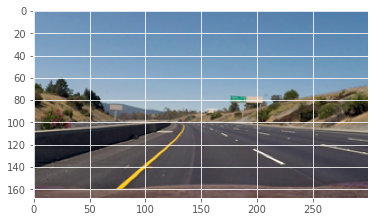

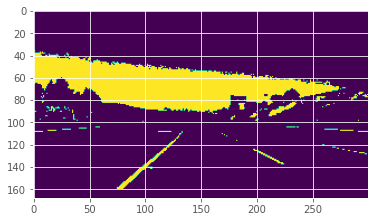

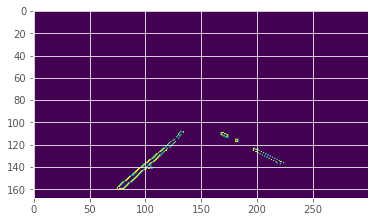

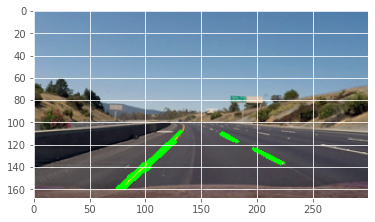

In [40]:
def region(image):
    height, width = image.shape
    triangle = np.array([
                       [(0, height), (width//2, 100), (width, height)]
                       ])
    
    mask = np.zeros_like(image)
    
    mask = cv2.fillPoly(mask, triangle, 255)
    mask = cv2.bitwise_and(image, mask)
    return mask

def average(image, lines):
    left = []
    right = []
    for line in lines:
        print(line)
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_int = parameters[1]
        if slope < 0:
            left.append((slope, y_int))
        else:
            right.append((slope, y_int))
            
def make_points(image, average): 
    slope, y_int = average 
    y1 = image.shape[0]
    y2 = int(y1 * (3/5))
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2])

def display_lines(image, lines):
    lines_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(lines_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return lines_image

i=1
basewidth = 300
img = Image.open("/Users/MattWalsh/Desktop/Files/School/CS6434/Project/frames/frame%d.jpg" % i)
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), Image.ANTIALIAS)
img = np.array(img)
plt.imshow(img)
plt.show()

# filter out white and yellow for lane lines
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
lower_yellow = np.array([20, 100, 100], dtype = "uint8")
upper_yellow = np.array([30, 255, 255], dtype="uint8")
mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
mask_white = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 170, 255)
mask_yw = cv2.bitwise_or(mask_white, mask_yellow)

gr = cv2. cvtColor(img, cv2.COLOR_BGR2GRAY)
yw = cv2.bitwise_or(mask_yw, mask_yellow)
plt.imshow(yw)
plt.show()

gaus = cv2.GaussianBlur(yw,(1,1), 0)

edges = cv2.Canny(gaus,50,150)

isolated = region(edges)
plt.imshow(isolated)
plt.show()

lines = cv2.HoughLinesP(isolated,rho = 2,theta = 1*np.pi/180,threshold = 10,minLineLength = 10,maxLineGap = 10)

for l in lines:
    l = l[0]
    cv2.line(img, (l[0], l[1]), (l[2], l[3]), (0, 255, 0), 2)
plt.imshow(img)
plt.show()